In [2]:
import torch
from torch.utils import data as data_
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision

In [3]:
#=========setting parameters
EPOCH = 1 
BATCH_SIZE = 100
LR = 0.01
DOWNLOAD_MNIST = False

torch.Size([60000, 28, 28])
torch.Size([60000])


/Users/tong/opt/anaconda3/envs/scikit_xgb/lib/python3.11/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/tong/opt/anaconda3/envs/scikit_xgb/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


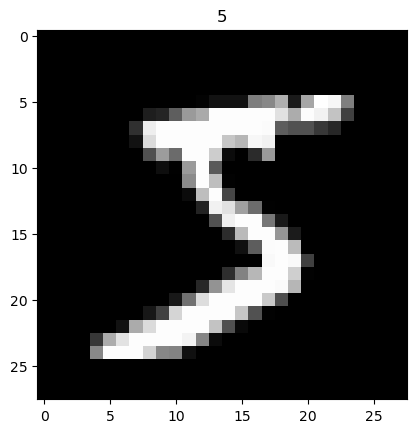

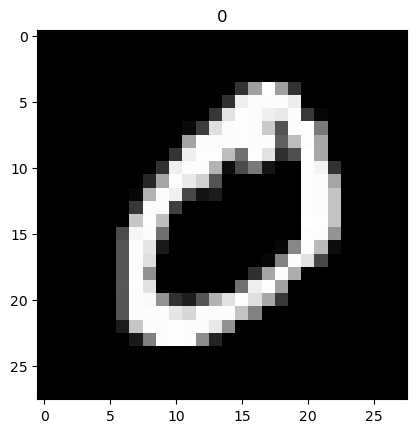

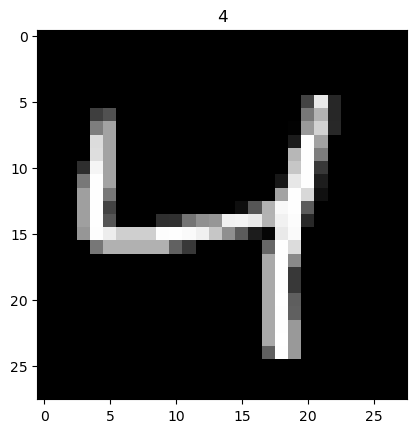

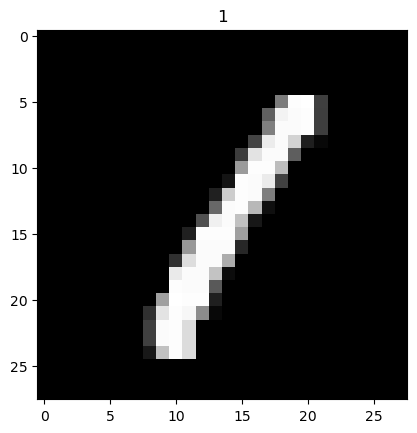

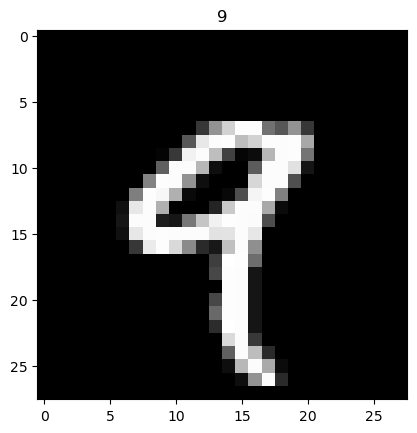

In [4]:
#=========load the dataset: mnist
train_data = torchvision.datasets.MNIST(root = '../mnist',
                                        train = True,
                                        transform = torchvision.transforms.ToTensor(),
                                        download = DOWNLOAD_MNIST)

print(train_data.train_data.size())
print(train_data.train_labels.size())

plt.ion()
for i in range(5):
      plt.imshow(train_data.train_data[i].numpy(), cmap = 'gray')
      plt.title(f"{train_data.train_labels[i]}")
      plt.pause(0.5)
plt.show()

In [5]:
# normalize data 
train_loader = data_.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

test_data = torchvision.datasets.MNIST(root = '../mnist/', train = False)
test_x = torch.unsqueeze(test_data.test_data, dim = 1).type(torch.FloatTensor)[:2000]/255.
test_y = test_data.test_labels[:2000]

/Users/tong/opt/anaconda3/envs/scikit_xgb/lib/python3.11/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/tong/opt/anaconda3/envs/scikit_xgb/lib/python3.11/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [8]:
### build the nn model 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, stride = 1, padding = 2,),
            nn.ReLU(),# corresponding data size: (16, 28, 28)
            nn.MaxPool2d(kernel_size = 2),# (16, 14, 14)
        )
        self.conv2 = nn.Sequential(# (16, 14, 14)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),# (32, 14, 14)
            nn.ReLU(),# (32,14,14)
            nn.MaxPool2d(2)# (32, 7, 7)
        )
        self.out = nn.Linear(32*7*7, 10)

    def forward(self, x): 
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [9]:
# define the optimizer
optimization = torch.optim.Adam(cnn.parameters(), lr=LR)   
# define the loss function 
loss_func = nn.CrossEntropyLoss()  


In [10]:
Loss_list = []
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        # input layer
        bx = Variable(batch_x)
        by = Variable(batch_y)
        # hidden layer and output layer
        output = cnn(bx)[0]
        #calculate loss function between predicted and accurate
        loss = loss_func(output, by)
        # clear gradient of parameters to 0
        optimization.zero_grad()
        # backward parpogation
        loss.backward()
        # updated parameters
        optimization.step()
        
        Loss_list.append(loss.data.numpy())
        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            

Epoch:  0 | train loss: 2.2902 | test accuracy: 0.20
Epoch:  0 | train loss: 0.0955 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1797 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1137 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0669 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0836 | test accuracy: 0.96


In [11]:
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


Text(0.5, 0, 'Step')

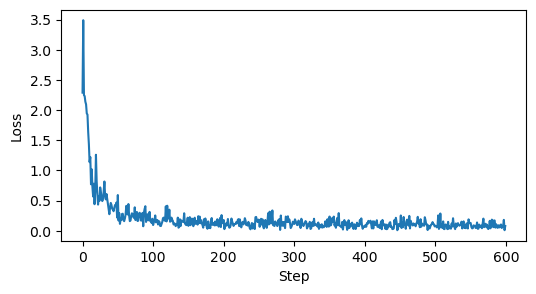

In [20]:
plt.figure(figsize=(6,3))
plt.plot(range(step+1), Loss_list)
plt.ylabel('Loss')
plt.xlabel('Step')